In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-pred/train.csv
/kaggle/input/house-prices-pred/test.csv


In [2]:
df=pd.read_csv('/kaggle/input/house-prices-pred/train.csv')
print(df.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

In [3]:
test_df=pd.read_csv('/kaggle/input/house-prices-pred/test.csv')
print(test_df.head())

     Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6

In [4]:
# Drop existing missing flags if they were added in earlier runs
df = df.loc[:, ~df.columns.str.startswith('missing_')]


In [5]:
# Drop existing missing flags if they were added in earlier runs
test_df = test_df.loc[:, ~test_df.columns.str.startswith('missing_')]


In [6]:
# Step 1: Add missing indicators
missing_flags = df.isnull().astype(int).add_prefix('missing_')
df = pd.concat([df, missing_flags], axis=1)

# Step 2: Ensure the column list exists and is correct
cols_to_check = [col for col in missing_flags.columns if col in df.columns]
cols_to_check.append('SalePrice')

# Step 3: Compute correlation
missing_corr = df[cols_to_check].corr(numeric_only=True)['SalePrice'].sort_values(ascending=False)

# Step 4: Display
print(missing_corr.head(20))

SalePrice               1.000000
missing_Fence           0.172184
missing_Alley           0.123611
missing_MiscFeature     0.072298
missing_MasVnrArea      0.051933
missing_LotFrontage     0.004087
missing_Electrical     -0.004424
missing_PoolQC         -0.093708
missing_BsmtFinType2   -0.145274
missing_BsmtExposure   -0.150231
missing_BsmtFinType1   -0.152829
missing_BsmtCond       -0.152829
missing_BsmtQual       -0.152829
missing_GarageType     -0.236832
missing_GarageYrBlt    -0.236832
missing_GarageFinish   -0.236832
missing_GarageQual     -0.236832
missing_GarageCond     -0.236832
missing_MasVnrType     -0.367456
missing_FireplaceQu    -0.471908
Name: SalePrice, dtype: float64


In [7]:
duplicates = test_df.columns[test_df.columns.duplicated()].tolist()
print("Duplicate columns:", duplicates)


Duplicate columns: []


In [8]:
# Define quality mapping (low to high)
quality_map = {
    'None': 0, 'NA': 0,
    'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5,
    'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6
}

# Fill missing with 'None' or 'NA' where appropriate
for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    df[col] = df[col].fillna('None')

# Map all 5 features using appropriate scale
df['BsmtQual_score'] = df['BsmtQual'].map(quality_map)
df['BsmtCond_score'] = df['BsmtCond'].map(quality_map)
df['BsmtExposure_score'] = df['BsmtExposure'].map({'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4})
df['BsmtFinType1_score'] = df['BsmtFinType1'].map(quality_map)
df['BsmtFinType2_score'] = df['BsmtFinType2'].map(quality_map)

# Create a composite score
df['BasementScore'] = df[
    ['BsmtQual_score', 'BsmtCond_score', 'BsmtExposure_score', 'BsmtFinType1_score', 'BsmtFinType2_score']
].sum(axis=1)


In [9]:
test_df = test_df.loc[:, ~test_df.columns.duplicated()]

In [10]:
#X_test_final = test_df.reindex(columns=X.columns, fill_value=0)


In [11]:
# Step 1: Add missing basement columns with default value 'None'
basement_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
for col in basement_cols:
    test_df[col] = 'None'  # add column with default category

# Step 2: Define quality mapping
quality_map = {
    'None': 0, 'NA': 0,
    'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5,
    'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6
}

# Step 3: Map each feature to a score
test_df['BsmtQual_score']      = test_df['BsmtQual'].map(quality_map)
test_df['BsmtCond_score']      = test_df['BsmtCond'].map(quality_map)
test_df['BsmtExposure_score']  = test_df['BsmtExposure'].map({'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4})
test_df['BsmtFinType1_score']  = test_df['BsmtFinType1'].map(quality_map)
test_df['BsmtFinType2_score']  = test_df['BsmtFinType2'].map(quality_map)

# Step 4: Create a composite score
test_df['BasementScore'] = test_df[
    ['BsmtQual_score', 'BsmtCond_score', 'BsmtExposure_score', 'BsmtFinType1_score', 'BsmtFinType2_score']
].sum(axis=1)


In [12]:
# -------- Step 1: Handle Missing Values -------- #
# Fill categorical features with 'None' (indicates no garage)
garage_cat_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
df[garage_cat_cols] = df[garage_cat_cols].fillna('None')

# Fill numerical garage year with 0 (indicates no garage)
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)

# -------- Step 2: Ordinal Mapping -------- #
garage_quality_map = {
    'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
}

garage_finish_map = {
    'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3
}

# Apply ordinal encoding
df['GarageQual_score'] = df['GarageQual'].map(garage_quality_map)
df['GarageCond_score'] = df['GarageCond'].map(garage_quality_map)
df['GarageFinish_score'] = df['GarageFinish'].map(garage_finish_map)

# -------- Step 3: Create Combined Feature -------- #
df['GarageScore'] = df[['GarageQual_score', 'GarageCond_score', 'GarageFinish_score']].sum(axis=1)

# -------- Optional: Drop Intermediate Columns -------- #
df.drop(columns=[
    'GarageQual', 'GarageCond', 'GarageFinish',
    'GarageQual_score', 'GarageCond_score', 'GarageFinish_score'
], inplace=True)


In [13]:
# -------- Step 1: Handle Missing Values -------- #
garage_cat_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

# Add missing columns if they don't exist
for col in garage_cat_cols + ['GarageYrBlt']:
    if col not in test_df.columns:
        test_df[col] = 'None' if col in garage_cat_cols else 0

# Fill categorical garage columns with 'None'
test_df.loc[:, garage_cat_cols] = test_df[garage_cat_cols].fillna('None')

# Fill GarageYrBlt with 0
test_df.loc[:, 'GarageYrBlt'] = test_df['GarageYrBlt'].fillna(0)

# -------- Step 2: Ordinal Mapping -------- #
garage_quality_map = {
    'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
}
garage_finish_map = {
    'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3
}

# Apply ordinal encoding
test_df.loc[:, 'GarageQual_score'] = test_df['GarageQual'].map(garage_quality_map)
test_df.loc[:, 'GarageCond_score'] = test_df['GarageCond'].map(garage_quality_map)
test_df.loc[:, 'GarageFinish_score'] = test_df['GarageFinish'].map(garage_finish_map)

# -------- Step 3: Create Combined Feature -------- #
test_df.loc[:, 'GarageScore'] = test_df[
    ['GarageQual_score', 'GarageCond_score', 'GarageFinish_score']
].sum(axis=1)

# -------- Optional: Drop Intermediate Columns -------- #
test_df.drop(columns=[
    'GarageQual', 'GarageCond', 'GarageFinish',
    'GarageQual_score', 'GarageCond_score', 'GarageFinish_score'
], inplace=True, errors='ignore')  # Use errors='ignore' to avoid issues if columns missing


In [14]:
# Engineered Features
df['TotalArea'] = df['GrLivArea'] + df['TotalBsmtSF']
df['AgeOfHouse'] = df['YrSold'] - df['YearBuilt']
df['YearsSinceRemod'] = df['YrSold'] - df['YearRemodAdd']
df['TotalBath'] = df['FullBath'] + 0.5 * df['HalfBath']
df['IsRemodeled'] = (df['YearBuilt'] != df['YearRemodAdd']).astype(int)
df['HasPorch'] = ((df['OpenPorchSF'] + df['EnclosedPorch'] +
                   df['3SsnPorch'] + df['ScreenPorch']) > 0).astype(int)


In [15]:
# ---------- Engineered Features for test_df ---------- #

# Safely create TotalArea
test_df['TotalArea'] = test_df['GrLivArea'] + test_df['TotalBsmtSF']

# Age-related features
test_df['AgeOfHouse'] = test_df['YrSold'] - test_df['YearBuilt']
test_df['YearsSinceRemod'] = test_df['YrSold'] - test_df['YearRemodAdd']

# Total bathrooms (Full + Half)
test_df['TotalBath'] = test_df['FullBath'] + 0.5 * test_df['HalfBath']

# Was the house remodeled?
test_df['IsRemodeled'] = (test_df['YearBuilt'] != test_df['YearRemodAdd']).astype(int)

# Check if the house has any kind of porch
test_df['HasPorch'] = (
    (test_df['OpenPorchSF'] + test_df['EnclosedPorch'] +
     test_df['3SsnPorch'] + test_df['ScreenPorch']) > 0
).astype(int)


In [16]:
print (df.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... BsmtFinType1_score BsmtFinType2_score  \
0         Lvl    AllPub  ...                  6                  1   
1         Lvl    AllPub  ...                  5                  1   
2         Lvl    AllPub  ...                  6                  1   
3         Lvl    AllPub  ...                  5                  1   
4         Lvl    AllPub  ...                  6                  1   

  BasementScore GarageScore TotalArea AgeOfHouse YearsSinceRemod  TotalBath  \
0            15           8      2566          5       

In [17]:
# Only use numerical features
numerical_df = df.select_dtypes(include=['int64', 'float64'])

# Get absolute correlation with target
correlation = numerical_df.corr()['SalePrice'].abs().sort_values(ascending=False)

# Top N correlated features
top_features = correlation[1:21]  # [1:] to exclude 'SalePrice' itself
print(top_features)


OverallQual            0.790982
TotalArea              0.778959
GrLivArea              0.708624
GarageCars             0.640409
GarageArea             0.623431
TotalBsmtSF            0.613581
1stFlrSF               0.605852
TotalBath              0.597966
BsmtQual_score         0.585207
FullBath               0.560664
TotRmsAbvGrd           0.533723
AgeOfHouse             0.523350
YearBuilt              0.522897
YearsSinceRemod        0.509079
YearRemodAdd           0.507101
MasVnrArea             0.477493
missing_FireplaceQu    0.471908
Fireplaces             0.466929
BasementScore          0.449858
GarageScore            0.434682
Name: SalePrice, dtype: float64


In [18]:
selected_features = top_features.index.tolist()
X = df[selected_features]
y = np.log1p(df['SalePrice'])
X = X.fillna(X.median())

In [19]:
print(X.isnull().sum().sort_values(ascending=False).head(10))

OverallQual            0
TotalArea              0
BasementScore          0
Fireplaces             0
missing_FireplaceQu    0
MasVnrArea             0
YearRemodAdd           0
YearsSinceRemod        0
YearBuilt              0
AgeOfHouse             0
dtype: int64


## Model Benchmarking

RMSE: 0.1589
R² Score: 0.8647


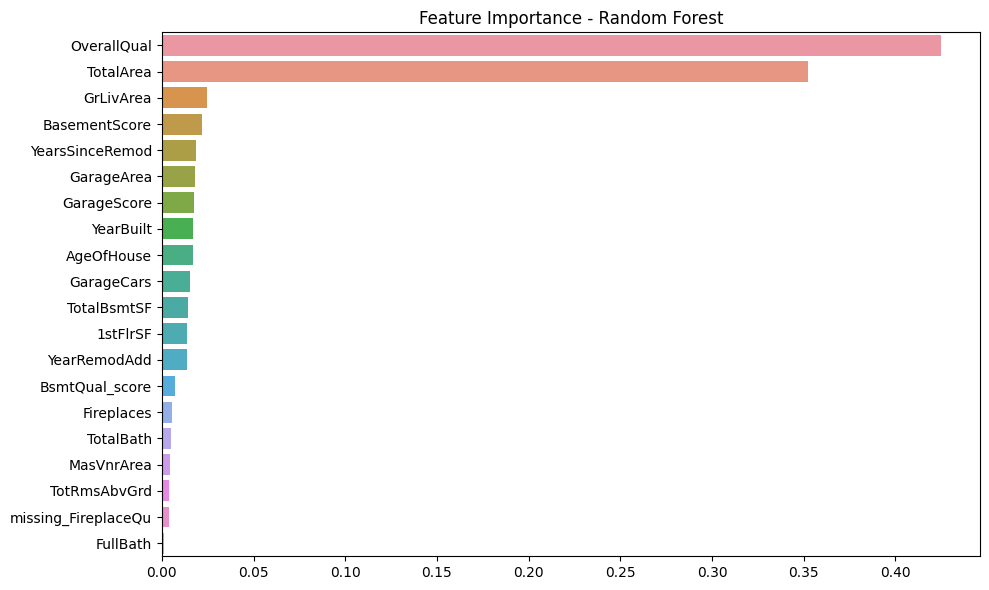

Cross-Validated RMSE: 0.1536


In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- 2. Train-Test Split (optional for local validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 3. Random Forest Model
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# --- 4. Predictions
y_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# --- 5. Feature Importance Plot
importances = rf.feature_importances_
feat_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_importance.values, y=feat_importance.index)
plt.title("Feature Importance - Random Forest")
plt.tight_layout()
plt.show()

# --- 6. Cross-validated RMSE
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='neg_root_mean_squared_error')
print(f"Cross-Validated RMSE: {-cv_scores.mean():.4f}")


In [21]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

# Select important features only
selected_features = [
    'OverallQual', 'TotalArea', 'GrLivArea', 'GarageCars', 'GarageArea',
    'TotalBsmtSF', '1stFlrSF', 'TotalBath', 'BsmtQual_score',
    'FullBath', 'TotRmsAbvGrd', 'AgeOfHouse', 'YearBuilt',
    'YearsSinceRemod', 'YearRemodAdd', 'MasVnrArea',
    'missing_FireplaceQu', 'Fireplaces', 'BasementScore', 'GarageScore'
]

X = df[selected_features].copy()
y = np.log1p(df['SalePrice'])

# Fill any missing values
X = X.fillna(X.median())

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Model
xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)
cv_rmse = -cross_val_score(xgb, X, y, cv=5, scoring='neg_root_mean_squared_error').mean()

print(f"XGBoost RMSE: {rmse:.4f}")
print(f"XGBoost R² Score: {r2:.4f}")
print(f"XGBoost Cross-Validated RMSE: {cv_rmse:.4f}")


XGBoost RMSE: 0.1571
XGBoost R² Score: 0.8678
XGBoost Cross-Validated RMSE: 0.1467


In [22]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# -------------------- Feature Selection -------------------- #
# Assume `top_features` is already computed using correlation with SalePrice
selected_features = top_features.index.tolist()

# Define X and y
X = df[selected_features]
y = np.log1p(df['SalePrice'])  # Log transform target for better modeling

# Handle missing values
X = X.fillna(X.median())

# -------------------- Train-Test Split -------------------- #
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------- Model Training -------------------- #
gb_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
gb_model.fit(X_train, y_train)

# -------------------- Evaluation -------------------- #
y_pred = gb_model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)
cv_rmse = -cross_val_score(gb_model, X, y, scoring='neg_root_mean_squared_error', cv=5).mean()

print(f"Gradient Boosting RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Cross-Validated RMSE: {cv_rmse:.4f}")
print(f"Approx % Error: {(rmse / np.expm1(y).mean()) * 100:.2f}%")


Gradient Boosting RMSE: 0.1551
R² Score: 0.8711
Cross-Validated RMSE: 0.1472
Approx % Error: 0.00%


In [23]:
y_val_inv = np.expm1(y_val)
y_pred_inv = np.expm1(y_pred)

actual_mean_price = y_val_inv.mean()
rmse_real = np.sqrt(mean_squared_error(y_val_inv, y_pred_inv))
error_percent = (rmse_real / actual_mean_price) * 100

print(f"Real-World RMSE: {rmse_real:.2f}")
print(f"Approx % Error: {error_percent:.2f}%")


Real-World RMSE: 29312.67
Approx % Error: 16.39%


In [24]:
# Ensure test_df has all selected_features from training
for col in selected_features:
    if col not in test_df.columns:
        test_df[col] = 0  # Add missing column with default value


In [25]:
import numpy as np
import pandas as pd

# Ensure selected features match what was used in training
selected_features = top_features.index.tolist()
X_test = test_df[selected_features]

# Handle missing values (same as in training)
X_test = X_test.fillna(X_test.median())

# Predict log prices
log_preds = gb_model.predict(X_test)

# Inverse log1p to get original scale
final_preds = np.expm1(log_preds)

# Create submission DataFrame
submission = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': final_preds
})

# Save to CSV
submission.to_csv('submission.csv', index=False)
print("✅ submission.csv saved!")


✅ submission.csv saved!
